![](../images/rivacon_frontmark_combined_header.png)

# Siamese Networks for Peer Group Scoring

This notebook illustrates the application of Siamese networks to construct a peer group scoring used to create peer groups for structured products. It shows a sample implementation to reproduce results from [this presentation](siamese.pdf) (example 1). It may be usefull to have a look on the presentation first.

In [1]:
import numpy as np
import tensorflow
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
%matplotlib inline

## Prepare and read data

The data is checked in as a comprezed zip folder. Therefore, we have to unzip it if we run this notebook for the first time.

In [2]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.') #unzip into current folder

The data has been created using two consistency constraints:

- **European_P1_P1_P1**:
$$d(C_{K,T},C_{K_1,T_1})\leq d(C_{K,T},C_{K_2,T_2}) \mbox{ for all } \|K-K_1\|\leq \|K-K_2\|,\|T-T_1\|\leq\|T-T_2\|, $$
$$d(P_{K,T},P_{K_1,T_1})\leq d(P_{K,T},P_{K_2,T_2}) \mbox{ for all } \|K-K_1\|\leq \|K-K_2\|,\|T-T_1\|\leq\|T-T_2\|, $$
where $C_{K,T}$ denotes a Call with strike K and maturity T.
 
 
- **European_P1_P1_P2**:
$$d(C_{K,T},C_{K_1,T_1})\leq d(C_{K,T},P_{K_2,T_2}) \mbox{ for all } K, K_1, K_2, T, T_1, T_2, $$
$$d(P_{K,T},P_{K_1,T_1})\leq d(P_{K,T},C_{K_2,T_2}) \mbox{ for all } K, K_1, K_2, T, T_1, T_2, $$

using 5 different implied volatilities: 10%, 15%, 20%, 25% and 30%. For each volatility and constrint we have 5 different files:
- 3 files defining the relations (anchor, positive, negative)
- 1 file containing the product informations (info)
- 1 file containing distances of the peer distance and the resulting $\alpha$ needed by the siamese network

The follwoing helpder functions read the different files and create the input data for the eural network.

### Helper Functions

In [3]:
def get_data(data, vols, data_dir):
    positive = None
    negative = None
    anchor = None
    info = None
    distance = None

    for vol in vols:
        for d in data:
            file_prefix = data_dir+d+'_' + str(vol)
            if positive is None:
                positive=pd.read_csv(file_prefix+'_positive.csv')#, index_col = 0))
                negative=pd.read_csv(file_prefix+'_negative.csv')#, index_col = 0))
                anchor=pd.read_csv(file_prefix+'_anchor.csv')#, index_col = 0))
                info=pd.read_csv(file_prefix+'_info.csv')#, index_col = 0))
                distance=pd.read_csv(file_prefix+'_distance.csv')#, index_col = 0))
            else:
                positive = positive.append(pd.read_csv(file_prefix+'_positive.csv'), ignore_index = True)#, index_col = 0))
                negative = negative.append(pd.read_csv(file_prefix+'_negative.csv'), ignore_index = True)#, index_col = 0))
                anchor = anchor.append(pd.read_csv(file_prefix+'_anchor.csv'), ignore_index = True)#, index_col = 0))
                info = info.append(pd.read_csv(file_prefix+'_info.csv'), ignore_index = True)#, index_col = 0))
                distance=distance.append(pd.read_csv(file_prefix+'_distance.csv'), ignore_index = True)#, index_col = 0))
    return anchor, positive, negative, info, distance

def get_training_data(data, vols, data_dir, shuffle = True, frac=1):
    anchor, positive, negative, info, distance = get_data(data, vols , data_dir)
    #now shuffle data
    if shuffle:
        anchor = anchor.sample(frac=frac)
        positive = positive.loc[anchor.index]
        negative = negative.loc[anchor.index]
        info = info.loc[anchor.index]
        distance = distance.loc[anchor.index]
    x_train=[anchor.values, positive.values, negative.values]
    y_train = distance.values
    return x_train, y_train, info

### ReadData

In [4]:
x_train, y_train, info = get_training_data(['European_P1_P1_P1','European_P1_P1_P2'], 
                                                   vols=[10,15,20,25,30], data_dir = './data/')

## Create and compile the Siamese Network Model

### Helper Functions
All functions to create the network with tensorflow/keras are encapsulated in the following code cell.

In [5]:
class SiameseNN:
    """This class encasulates all functions needed to create the siamese network for peer group scoring
    """

    @staticmethod
    def _triplet_loss_alpha(y_true, y_pred):
        """
        Implementation of the triplet loss function where alpha is taken from y_true
        Arguments:
        y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
        y_pred -- python list containing three objects:
                anchor -- the encodings for the anchor data
                positive -- the encodings for the positive data (similar to anchor)
                negative -- the encodings for the negative data (different from anchor)
        Returns:
        loss -- real number, value of the loss

        $$L=\max(d(A,P)-d(A,N)+\alpha,0)$$
        """
        total_lenght = y_pred.shape[-1]

        anchor = y_pred[:,0:int(total_lenght/3)]
        positive = y_pred[:,int(total_lenght/3):int(total_lenght*2/3)]
        negative = y_pred[:,int((total_lenght*2)/3):int(total_lenght)]

        # distance between the anchor and the positive
        pos_dist = keras.backend.sum(keras.backend.square(anchor-positive),axis=1)

        # distance between the anchor and the negative
        neg_dist = keras.backend.sum(keras.backend.square(anchor-negative),axis=1)

        # compute loss
        #return keras.backend.mean(keras.backend.maximum(pos_dist-neg_dist+0.1,0.0))
        #print(keras.backend.mean(depp.shape))
        #print(keras.backend.mean(y_pred[:,3]))
        return keras.backend.maximum(pos_dist-neg_dist+0.5*y_true[:,3],0.0)

    @staticmethod
    def load(file):
        """Load a model from file.

        Thismethod simply uses the keras built-in method keras.models.load_model where the specialized loss function is specified in custom_objects

        Args:
            file (str): The filename of fil containing model

        Returns:
            tensorflow model: The siamese network
        """
        #if newest_subdir is None:
        return keras.models.load_model(file, custom_objects={'_triplet_loss_alpha': SiameseNN._triplet_loss_alpha})

    @staticmethod
    def get_submodel(m):
        """Return the inner model of the siamese network

        Args:
            m (keras model): The siamese network

        Returns:
            [keras model]: The inner network of the siamese model
        """
        return m.get_layer(name='distance_model')
         
    @staticmethod
    def _create_simple_network(n_neurons, activation='relu',
                        kernel_regularizer=None, bias_regularizer=None, 
                        input_dim=1, 
                        normalize_output=False):
        """Create the network model used as inner model of the siamese network

            Args:
                n_neurons (int): Number of neurons
                activation (str, optional): The keras activation function used in the inner network. Defaults to 'relu'.
                kernel_regularizer (regularizer from keras.regularizers, optional): A possible kernel_regularizer. Defaults to None.
                bias_regularizer (regularizer from keras.regularizers, optional): A bias regularizer. Defaults to None.
                input_dim (int, optional): Input dimension. Defaults to 1.
                normalize_output (bool, optional): Flag that determines if the output is normalized. Defaults to False.

            Returns:
                [model from keras.models]: The resulting inner network
        """
        keras.backend.clear_session()
        np.random.seed(42)
        model = keras.models.Sequential(name='distance_model')
        model.add(keras.layers.Dense(n_neurons[0], activation=activation, input_dim=input_dim, kernel_regularizer=kernel_regularizer, 
                        bias_regularizer=bias_regularizer, name='distance_model_layer_0')) 
        for i,n in enumerate(n_neurons[1:]):
            name='distance_model_layer_'+str(i+1)
            model.add(keras.layers.Dense(n, activation=activation, kernel_regularizer=kernel_regularizer, 
                        bias_regularizer=bias_regularizer,  name=name)) 
        if normalize_output:
            model.add(keras.layers.Lambda(lambda t: keras.backend.l2_normalize(t, axis=1)))
        return model

    @staticmethod
    def create(n_neurons, activation='relu', kernel_regularizer=None,
            bias_regularizer=None, input_dim=1, optimizer = None, 
            normalize_output = False):
        """If optimizer is not None, it also directly compiles the model
        """
        model = SiameseNN._create_simple_network(n_neurons, activation=activation, 
                kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer, 
                input_dim=input_dim, normalize_output=normalize_output)
        input_dim = model.layers[0].input_shape[1]
        # Define the tensors for the three input images
        anchor_input = keras.layers.Input((input_dim, ), name="anchor_input")
        positive_input = keras.layers.Input((input_dim, ), name="positive_input")
        negative_input = keras.layers.Input((input_dim, ), name="negative_input") 
        
        # Generate the encodings (feature vectors) for the three images
        encoded_a = model(anchor_input)
        encoded_p = model(positive_input)
        encoded_n = model(negative_input)
        
        merged_vector = keras.layers.concatenate([encoded_a, encoded_p, encoded_n], axis=-1, name='merged_layer')
        #merged_vector = keras.backend.stack([encoded_a, encoded_p, encoded_n])
        # Connect the inputs with the outputs
        siamese = keras.models.Model(inputs=[anchor_input,positive_input,negative_input],outputs=merged_vector, name='siamese')
        if optimizer is not None:
            siamese.compile(loss=SiameseNN._triplet_loss, optimizer=optimizer)
        return siamese

### Create the Siamese Network

In the next code cell we define a new Siamese network with
- Three layers (15 neurons in the first layer, 10 in the second and 3 in the output layer)
- As activation functions we use elu
- We do not apply any regularization

In [6]:
model = SiameseNN.create(n_neurons=(15,10,3,), 
                                 activation='elu',
                                 kernel_regularizer=None, 
                                 bias_regularizer=None, 
                                 input_dim =x_train[0].shape[1], 
                                 normalize_output = False)

In [7]:
model.compile(loss=SiameseNN._triplet_loss_alpha, 
              optimizer = keras.optimizers.Adam(lr=0.00035, beta_1=0.9, beta_2=0.999))

### Fit the model

If you execute the following cell, the model will be fit. Alternatively, to save computation time, you may load a pretrained model that we have also checked in. For this, uncomment the code in the second next cell and run it. 

In [8]:
log_dir = 'logdir' + '\\' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
cb = [keras.callbacks.TensorBoard(profile_batch=0, log_dir=log_dir, histogram_freq=100),]
cb.append(keras.callbacks.ModelCheckpoint( log_dir+ '\\best_model.h5', save_best_only = True))

history = model.fit(x_train,
                    y_train,
                    epochs=1000,
                    batch_size=2000,
                    verbose=0,
                    callbacks=cb,
                    validation_split=0.2)

In [9]:
# uncomment the following line to read a pretrained model
#model = SiameseNN.load('best_model.h5')
#model.summary()

## Model analysis

### Helper Functions

In [10]:
def apply_model(info, anchor, positive, negative, distance):
    m = SiameseNN.get_submodel(model) #get the submodel
    anchor_pred=m.predict(anchor)
    positive_pred=m.predict(positive)
    negative_pred = m.predict(negative)
    dist_pos = np.linalg.norm(anchor_pred-positive_pred, axis=1)
    dist_neg = np.linalg.norm(anchor_pred-negative_pred, axis=1)
    
    info['peer_distance_d1'] = distance['d_pos']
    info['peer_distance_d2'] = distance['d_neg']
    
    info['d_2']=dist_neg
    info['d_1']=dist_pos
    info['diff']=dist_neg-dist_pos
    
    return info


def plot_validation(info, anchor, positive, negative, distance, prefix=''):
    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    m = SiameseNN.get_submodel(model) #get the submodel
    for payoff in info['anchor_payoff'].unique():
        pred = m.predict(anchor[info['anchor_payoff']==payoff])
        plt.scatter(pred[:,0], pred[:,1], s=5.0, label=payoff)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    
    plt.subplot(2,2,2)
    anchor_pred=m.predict(anchor)
    positive_pred=m.predict(positive)
    negative_pred = m.predict(negative)
    dist_pos = np.linalg.norm(anchor_pred-positive_pred, axis=1)
    dist_neg = np.linalg.norm(anchor_pred-negative_pred, axis=1)
    info['peer_distance_d1'] = distance['d_pos']
    info['peer_distance_d2'] = distance['d_neg']
    info['d_2']=dist_neg
    info['d_1']=dist_pos
    info['diff']=dist_neg-dist_pos
    plt.plot(info['diff'],'.')
    info.sort_values(by='diff', inplace=True,ascending=True)
    plt.xlabel('datapoint')
    plt.ylabel('$d_2-d_1$')
        
    plt.subplot(2,2,3)
    info.sort_values(by='d_1', inplace=True, ascending = True)
    plt.plot(info['d_1'],'.', label='siamese distance')
    plt.plot(info['peer_distance_d1'],'.', label='reference distance')
    plt.legend()
        
    plt.subplot(2,2,4)
    np.min(dist_neg-dist_pos)
    plt.hist(dist_neg-dist_pos, bins=100)
    plt.xlabel('$d_2-d_1$')
    plt.ylabel('num datapoints');
    return info


import numpy as np


def compute_similarity(f1,f2):
    dx_f1 = f1[1:]-f1[:-1]
    d1 = np.sqrt(np.sum(dx_f1*dx_f1))
    dx_f2 = f2[1:]-f2[:-1]
    d2 = np.sqrt(np.sum(dx_f2*dx_f2))
    if d1 < 0.00001 or d2 < 0.00001:
        if d1 > 0.0001 or d1 > 0.0001:
            # no similarity: Constant and non-constant
            return 0.0
        else:
            # very similar since both seem to be constants
            return 0.98
    return np.minimum(np.dot(dx_f1, dx_f2)/(d1*d2), 1.0)

def compute_similarity_dist(f1,f2):
    dx_f1 = f1[1:]-f1[:-1]
    d1 = np.sqrt(np.sum(dx_f1*dx_f1))
    dx_f2 = f2[1:]-f2[:-1]
    d2 = np.sqrt(np.sum(dx_f2*dx_f2))
    if d1 < 0.00001 or d2 < 0.00001:
        if d1 > 0.0001 or d1 > 0.0001:
            # no similarity: Constant and non-constant
            return 0.0
        else:
            # very similar since both seem to be constants
            return 0.98
    return 1.0-compute_similarity(f1,f2)

def compute_l2_distance(f1,f2):
    return np.linalg.norm(f1-f2, ord=2)/float(f1.shape[0])

def compute_h1_semi_distance(f1,f2):
    return np.linalg.norm(np.diff(f1-f2, n=1), ord=2)/float(f1.shape[0])

def compute_h2_semi_distance(f1,f2):
    return np.linalg.norm(np.diff(f1-f2, n=2), ord=2)/float(f1.shape[0])

def compute_peer_distance(f1,f2):
    return (1.5-compute_similarity(f1,f2))*compute_h1_semi_distance(f1,f2)

measures = {
    'similarity': compute_similarity,
    'similarity_dist': compute_similarity_dist,
    'l2' : compute_l2_distance,
    'h1': compute_h1_semi_distance,
    'h2': compute_h2_semi_distance,
    'peer':  compute_peer_distance
}

def compute(g1,g2,dist, matrix = False):
    if len(g1.shape) > len(g2.shape):
        f1 = g2
        f2 = g1
    else:
        f1 = g1
        f2 = g2
    if isinstance(dist, str): # from callable to string
        dist = measures[dist]
    if matrix:
        if len(f1.shape) != len(f2.shape):
            raise Exception('g1 and g2 must have same shape for matrix computation')
        result = np.empty((f1.shape[0], f1.shape[0],))
        for i in range(f1.shape[0]):
            for j in range(i, f1.shape[0]):
                result[i,j] = dist(f1[i,:], f2[j,:])
                result[j,i] = result[i,j]
    else:
        result = np.empty((f2.shape[0],))
        if len(f1.shape)>1:
            for i in range(f2.shape[0]):
                result[i] = dist(f1[i,:], f2[i,:])
        else:
            for i in range(f2.shape[0]):
                result[i] = dist(f1[:], f2[i,:])
    return result

def compute_inconsistencies(vols, data, data_dir = 'data\\'):
    measures = ['l2', 'h1', 'similarity_dist']
    from collections import defaultdict
    result = defaultdict(list)

    for vol in vols:
        for d in data:
            anchor, positive, negative, info, distance = get_data([d], vols = [vol], data_dir = data_dir)
            apply_model(info, anchor, positive, negative, distance)
            result['data'].append(d)
            result['vol'].append(str(vol))
            result['data size'].append(info.shape[0])
            result['siamese'].append(info[info.d_1>info.d_2].shape[0])
            result['peer'].append(info[info.peer_distance_d1>info.peer_distance_d2].shape[0])
            for m in measures:
                pos = compute(anchor.values[:,:-3], positive.values[:,:-3], m, matrix=False)
                neg = compute(anchor.values[:,:-3], negative.values[:,:-3], m, matrix=False)
                result[m].append(pos[pos>neg].shape[0])
    total = sum(result['data size'])
    result['data size'].append(total)
    result['data'].append('total')
    result['siamese'].append(sum(result['siamese']))
    result['peer'].append(sum(result['peer']))
    result['vol'].append(None)

    for m in measures:
        result[m].append(sum(result[m]))
    inconsistencies = pd.DataFrame(result)
    columns = [c for c in inconsistencies.columns]
    for c in columns:
        if c in ['data', 'data size', 'vol']:
            continue
        inconsistencies[c+' %'] = 100.0*inconsistencies[c]/inconsistencies['data size']
    return inconsistencies

In [11]:
anchor, positive, negative, info, distance = get_data(['European_P1_P1_P1','European_P1_P1_P2'], 
                                                   vols=[10,15,20,25,30], data_dir = './data/')

### Plots

The following plots give an impression on the functionality of the network and on the scoring. The first figure (upper left) plots the output of network (which is twodimesnional by the above construction). Note that the plotting of this figure needs to be adjusted if you modify the output dimension of the inner network. The second figure (upper right) shows the difference between the distance between the anchor point and the negative point and the distance to the positive point, which should be closer to the anchor. Note that values below zero represent **inconsistencies** where the constraint are not fullfilled. The bottom left figure shows the siamese distance vs the original peer scoring distance and the last figure the histogram of the points of the upper right figure.

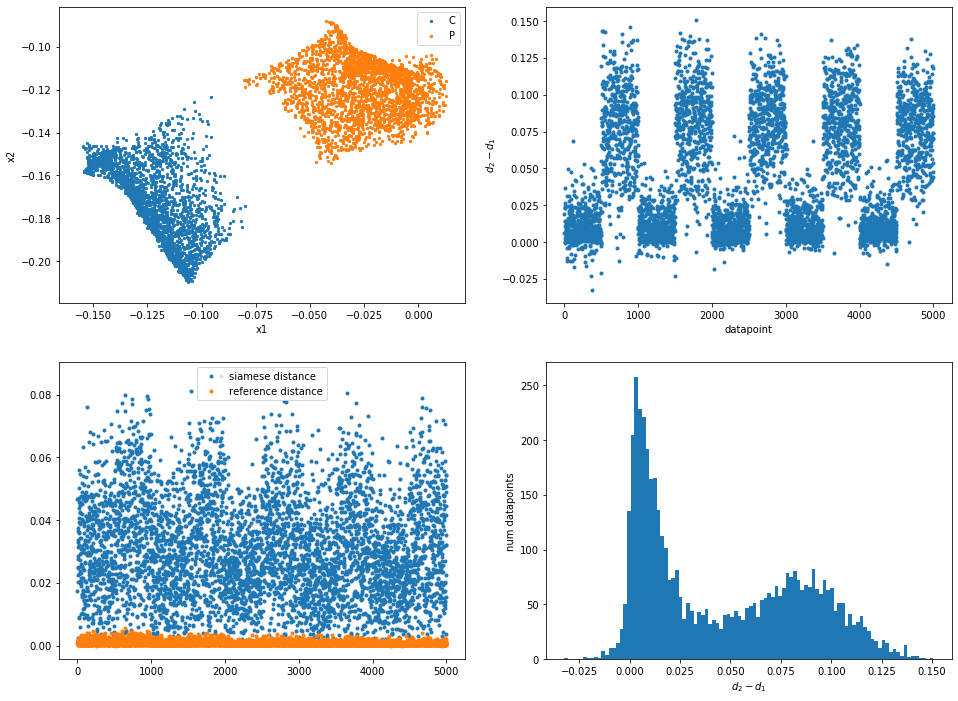

In [12]:
info = plot_validation(info, anchor, positive, negative, distance)

### Inconsistencies

In [13]:
pd.options.display.max_rows=None
inconsistencies = compute_inconsistencies(vols=[10,15,20,25,30], data=['EUROPEAN_P1_P1_P1','EUROPEAN_P1_P1_P2'], data_dir='data\\')
inconsistencies

,data,vol,data size,siamese,peer,l2,h1,similarity_dist,siamese %,peer %,l2 %,h1 %,similarity_dist %
0,EUROPEAN_P1_P1_P1,10,500,47,82,90,83,138,9.40,16.40,18.0,16.60,27.60
1,EUROPEAN_P1_P1_P2,10,500,3,10,87,34,0,0.60,2.00,17.4,6.80,0.00
2,EUROPEAN_P1_P1_P1,15,500,35,87,98,91,139,7.00,17.40,19.6,18.20,27.80
3,EUROPEAN_P1_P1_P2,15,500,2,4,71,23,0,0.40,0.80,14.2,4.60,0.00
4,EUROPEAN_P1_P1_P1,20,500,43,86,107,86,136,8.60,17.20,21.4,17.20,27.20
5,EUROPEAN_P1_P1_P2,20,500,0,0,53,9,0,0.00,0.00,10.6,1.80,0.00
6,EUROPEAN_P1_P1_P1,25,500,32,78,112,79,128,6.40,15.60,22.4,15.80,25.60
7,EUROPEAN_P1_P1_P2,25,500,1,0,68,8,0,0.20,0.00,13.6,1.60,0.00
8,EUROPEAN_P1_P1_P1,30,500,29,83,98,82,117,5.80,16.60,19.6,16.40,23.40
9,EUROPEAN_P1_P1_P2,30,500,0,1,71,2,0,0.00,0.20,14.2,0.40,0.00
